In [30]:
import json
from pathlib import Path
import shutil

import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

from dotenv import load_dotenv, find_dotenv

tqdm.pandas()

load_dotenv(find_dotenv(), override=True)

True

## Load document JSONs

In [2]:
# Note from Kalyan: I still can't get s3 to work in a notebook, so the code loads from 
# the local filesystem for now. The s3 dir below contains the data you need to get this
# running.
# documents_s3_path = "s3://project-rag/data/cpr_embeddings_output"

documents_path = Path("/Users/kalyan/Documents/CPR/rag-labs/data/cpr_embeddings_output_final").expanduser()

assert documents_path.exists()

documents_by_id = {}

for path in tqdm(list(documents_path.glob("*.json"))):
    document_id = path.stem
    try:
        documents_by_id[document_id] = json.loads(path.read_text())
    except Exception as e:
        print(f"Failed to load {document_id}: {e}")

  0%|          | 0/715 [00:00<?, ?it/s]

## Exploratory analysis - find near-empty docs and docs with corrupted text

In [3]:
def get_page_text(document: dict, first_n_pages: int) -> list[str]:
    """Get text from specific pages, or all pages if the document is an HTML document."""
    
    if document["pdf_data"] is not None:
        blocks = document["pdf_data"]["text_blocks"]
        return [" ".join(block["text"]) for block in blocks if block["page_number"] < first_n_pages]
    elif document["html_data"] is not None:
        blocks = document["html_data"]["text_blocks"]
        return [" ".join(block["text"]) for block in blocks]
    else:
        return []


In [4]:
document_text_df = pd.DataFrame(
    {
        "document_id": document_id,
        "all_text": " ".join(get_page_text(document_dict, 10000))
    }
    for document_id, document_dict in documents_by_id.items()
)

document_text_df.head(2)

,document_id,all_text
0,CCLW.legislative.8544.rtl_85,OFFICIAL JOURNAL OF THE GRAND DUCHÉ DE LUXEMBO...
1,UNFCCC.party.1535.0,


<Axes: xlabel='text_n_words', ylabel='Count'>

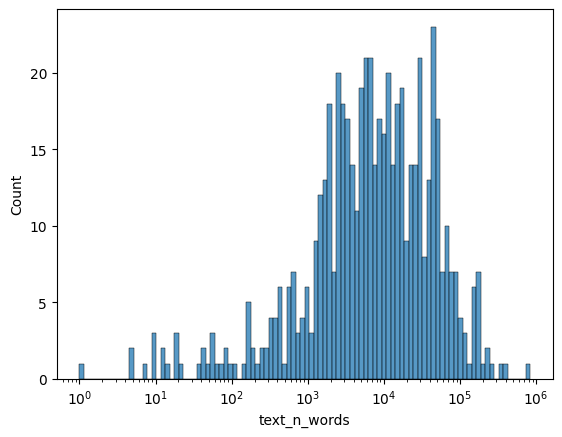

In [5]:
from collections import Counter

def alphanumeric_ratio(text: str) -> float:
    """Calculate the proportion of alphanumeric characters in a text."""
    if len(text) == 0:
        return 0.0
    
    text = text.lower()
    char_freq = Counter(text)
    total_chars = len(text)

    alphanumeric = 'abcdefghijklmnopqrstuvwxyz0123456789'
    alpha_numeric_freq = sum(char_freq[c] for c in alphanumeric)
    alpha_ratio = alpha_numeric_freq / total_chars
    
    return alpha_ratio

document_text_df["text_n_words"] = document_text_df["all_text"].apply(lambda x: len(x.split()))
document_text_df["is_empty"] = document_text_df["text_n_words"] == 0
document_text_df["alpha_ratio"] = document_text_df["all_text"].apply(alphanumeric_ratio)

sns.histplot(document_text_df["text_n_words"], bins=100, log_scale=True)

<Axes: xlabel='alpha_ratio', ylabel='Count'>

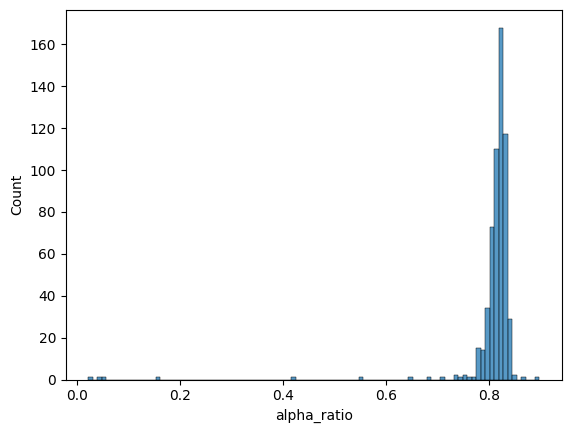

In [6]:
sns.histplot(document_text_df.loc[document_text_df["is_empty"] == False, "alpha_ratio"], bins=100)

### text length

`min_words == 100` seems like a good minimum threshold

In [7]:
min_words = 100

with pd.option_context("display.max_colwidth", None):
    display(
        document_text_df[document_text_df["text_n_words"] > min_words].sort_values("text_n_words").head(5)
    )

,document_id,all_text,text_n_words,is_empty,alpha_ratio
215,CCLW.document.i00000442.n0000,"%PDF-1.5 %���� 23 0 obj &lt;&gt; throw in 31 0 obj &lt;&gt;/Filter/FlateDecode/ID[&lt;34EA4E37C4B67E41A7771A9A9EE186D6&gt;&lt;34EA4E37C4B67E41A7771A9A9EE186D6&gt;]/Index[23 18]/Info 22 0 R/Length 59/Prev 66785/Root 24 0 R/Size 41/Type/XRef/W[1 2 1]&gt;&gt;stream h�bbd``b`��@��\tH0��D} ^\t$�Ab�'����10 �3n�\t` =?� endstream throw in startxref 0 %%EOF 40 0 obj &lt;&gt;stream h�b```f``2e`b``�� �� @ �8p:����!��B�v����� D��ui6 ��41�30p���&amp;0�:��0��,���ȼH3�@� +4 endstream throw in 24 0 obj &lt;&gt;&gt;&gt; throw in 25 0 obj &lt;&gt; throw in 26 0 obj &lt;&gt;stream h޴�mO�0ǿʽ܄��8���Jy�@$bC�&lt;��6�1������\���]�wN~(����D ���F5���E����������d�c�Z��~�0 ��шL��u�$��ٜ���� �T����&amp;6����MIb���h��&lt;9�?i^���7�I�z0/��qyc���af��{Jq�g*�6w�i�ޕ�|m�I�t�͔v.��������wN�y���$�ܔ_+K��* ?ӹ!㣋�Y���ϊy� 6ͳ���.7@Il�|Zzq��� ��e�`�%�],ꙙ�������lY���t �� ʃO�;N�0?^[�2Y&gt;�w[ ������ҝ4C���4��π�c� Wjo�db��W��#��=��O�� P^��;���Z�l��^��o|���F;��|XOwm���Y�p�Ǧ�n���ZcN:0������13]3J�~2b�Q���uwV���j����Z�l���� �7�r��nu�������E�դ�o�e""��eB�W�&gt;�o7X˭zŭ��ms� ��a���OlKҋ�դ ���ג��M\Mo7�;d�B\���^[X�u�h�u�{�+Kt|��������G߀Ͳu(�GY�&lt;��.�5w��\���5�h���W��""�1��;9�mU����u��&gt;W�$/L�P��J��������,� t�*| endstream throw in 27 0 obj &lt;&gt;stream H�tV pT���}owY�($�$��#!B�@�@��v4�����k6�DW�d~fP&amp;v�V��h�JQ�,OL���D��h[J������L�b-��ݗ f�g�=�{��9�.@O�@C�&amp;k�O�&gt;x1�j�6?�0��G =oA�„��������O,_� ��Wꁢ��Yu���т�瀍́�::zd��Y\�K4-{q��]\���{bQM쾆i� k�����-k���� o&lt;�3�x2��;����|�h\���&lt;�٠��ƧjK ?m70�pp5A���O�h�q7`�%.���K `�E+� �6��0E�C3�0s3N�&gt;d�g�x��pg� �� ~�]b2�xeH�r��!���r,bl%^���nachrichten?���� ���&quot;�3�:�l�k� ������F���pN`$rQȜ h~�d�b&lt;�ۂ�qZ��ǣFc�X�:$�$���8���#xO%�b-�~+��b�����!��{� ��y\}�q�γ�l�w�� g +�a;~�*�!�9\3�\��F���1�.v-�*&lt;� &lt;�J�����ŢT���E$�!Y� New ��c�} ��c����&#39;n�����&amp;N������&gt;�iIm�}�~�5�՚~3}�^ho���Y�� ��/��X�1�1���ǝ��2����w�q�piQ�:ǈ 1O�;�AqD | Error",116,False,0.418329
513,CCLW.executive.11053.6353,"Government has approved Phase-II of FAME Scheme with an outlay of Rs. 10,000 Crore for a period of 3 years commencing from 1st April 2019. Out of total budgetary support, about 86 percent of fund has been allocated for Demand Incentive so as to create demand for xEVs in the country. This phase aims to generate demand by way of supporting 7000 e-Buses, 5 lakh e-3 Wheelers, 55000 e-4 Wheeler Passenger Cars (including Strong Hybrid) and 10 lakh e-2 Wheelers. However, depending upon off-take of different category of xEVs, these numbers may vary as the provision has been made for inter as well as intra segment wise fungibility. Only advanced battery and registered vehicles will be incentivized under the scheme. With greater emphasis on providing affordable & environment friendly public transportation options for the masses, scheme will be applicable mainly to vehicles used for public transport or those registered for comme... [Read More]",153,False,0.810782
596,CCLW.executive.10211.4813,"Main guidelines: Excerpts from the Royal Speech of October 12, 2018 &quot;The agricultural sector can be a more efficient provider of jobs and a more effective instrument for ensuring better living and settlement conditions in rural areas&quot; “We call for the consolidation of the achievements made in the agricultural sector and the creation of new job-generating and income-generating activities, particularly for young people in rural areas” &quot;Our goal is to promote the emergence of an agricultural middle class&quot; &quot;We are guiding the government to develop innovative mechanisms to encourage farmers to join more cooperatives and productive agricultural groups&quot; &quot;We call for the strengthening and facilitation of investors&#39; access to land&quot; “Doing justice to small farmers, especially in the marketing of their products” &quot;The mobilization of agricultural land belonging to ethnic communities for the realization of agricultural investment projects, constitut

### alphanumeric ratio

This is too fuzzy a metric to set a precise threshold, but 0.5 seems sensible.

In [24]:
min_alphanumeric_ratio = 0.6

document_text_df_nonempty = document_text_df[document_text_df["is_empty"] == False]

# display documents with a ratio below the minimum to see what's excluded
with pd.option_context("display.max_colwidth", 1000):
    display(
        document_text_df_nonempty[document_text_df_nonempty["alpha_ratio"] < min_alphanumeric_ratio].sort_values("alpha_ratio").head(10)
    )

,document_id,all_text,text_n_words,is_empty,alpha_ratio
334,CCLW.executive.10393.5088,å›½åŠ¡é™¢åŠžå…¬åŽ…å…³äºŽå °å &#39;è¦ ç´ å¸‚åœºåŒ–é… ç½® ç»¼å ˆæ”¹é ©è¯•ç‚¹æ€»ä½“æ–¹æ¡ˆçš„é€šçŸ¥ å›½åŠžå &#39;ã€”2021ã€•51yr · å „çœ ã€ è‡ªæ²»åŒºã€ ç›´è¾–å¸‚äººæ°&#39;æ”¿åºœï¼Œå›½åŠ¡é™¢å „éƒ¨å§”ã€ å „ç›´å±žæœºæž„ ï¼š ã€Šè¦ ç´ å¸‚åœºåŒ–é… ç½®ç»¼å ˆæ”¹é ©è¯•ç‚¹æ€»ä½“æ–¹æ¡ˆã€‹å·²ç» å›½åŠ¡é™¢ å Œæ„ ï¼ŒçŽ°å °å &#39;ç»™ä½ ä»¬ï¼Œè¯·è®¤çœŸç»„ç»‡å®žæ–½ã€‚ å›½åŠ¡é™¢åŠžå…¬åŽ 2021å¹´12æ21æ¥ ï¼ˆæ¤ä»¶å…¬å¼€å &#39;å¸ƒï¼‰ è¦ ç´ å¸‚åœºåŒ–é… ç½®ç»¼å ˆæ”¹é ©è¯•ç‚¹æ€»ä½“æ–¹æ¡ˆ ä¸ºæ·±å…¥è´¯å½»è ½å®žã€Šä¸å…±ä¸å¤®ã€€å›½åŠ¡é™¢å…³äºŽæž„å»ºæ›´åŠ å® Œå–„çš„è¦ ç´ å¸‚åœºåŒ–é… ç½®ä½“åˆ¶æœºåˆ¶çš„æ„ è§ ã€‹ï¼ŒçŽ°å°±ç§¯æž ç¨³å¦¥å¼€å ±•è¦ ç´ å¸‚åœºåŒ–é… ç½®ç»¼å ˆæ”¹é ©è¯•ç‚¹å·¥ä½œåˆ¶å®šæœ¬æ–¹æ¡ˆã€‚ ä¸€ã€ æ€»ä½“è¦ æ±‚ ï¼ˆä¸€ï¼‰æŒ‡å¯¼æ€ æƒ³ã€‚ä»¥ä¹ è¿&#39;å¹³æ–°æ—¶ä»£ä¸å›½ç‰¹è‰²ç¤¾ä¼šä¸»ä¹‰æ€ æƒ³ä¸ºæŒ ‡å¯¼ï¼Œå…¨é ¢è´¯å½»è ½å®žå…šçš„å ä¹ å¤§å&#39;Œå ä¹ å±ŠåŽ†æ¬¡å…¨ä¼šç²¾ç¥žï¼Œå¼˜æ‰¬ä¼Ÿå¤§å »ºå…šç²¾ç¥žï¼Œå šæŒ ç¨³ä¸æ±‚è¿›å·¥ä½œæ€»åŸºè°ƒï¼Œå®Œæ•´ã€ å‡†ç¡®ã€ å…¨é ¢è´¯å½» æ–°å &#39;å±•ç †å¿µï¼ŒåŠ å¿«æž„å»ºæ–°å &#39;å±•æ ...,1587,False,0.022782
658,CCLW.legislative.1315.4615,å›½èƒ½å &#39;æ–°èƒ½ã€”2021ã€•25å · å›½å®¶èƒ½æº å±€å…³äºŽ2021å¹´é£Žç”µã€ å…‰ä¼ å &#39;ç”µå¼€å &#39;å»ºè®¾æœ‰å…³äº‹é¡¹çš„é€šçŸ¥ å ›½èƒ½å &#39;æ–°èƒ½ã€”2021ã€•25å · å›½å®¶èƒ½æº å±€å…³äºŽ2021å¹´é£Žç”µã€ å…‰ä¼ å &#39;ç”µ å¼€å &#39;å»ºè®¾æœ‰å…³äº‹é¡¹çš„é€šçŸ¥ å›½èƒ½å &#39;æ–°èƒ½ã€”2021ã€•25å · å „çœ ï¼ˆè‡ªæ²»åŒºã€ ç›´è¾–å¸‚ï¼‰èƒ½æº å±€ï¼Œæœ‰å…³çœ ï¼ˆè‡ªæ²»åŒºã€ ç›´è¾–å¸‚ï¼‰å Šæ–°ç– †ç”Ÿäº§å»ºè®¾å…µå›¢å &#39;å±•æ”¹é ©å§”ï¼Œå „æ´¾å‡ºæœºæž„ï¼Œå›½å®¶ç”µç½&#39;ã€ å —æ–¹ç ”µç½&#39;ã€ å†…è&#39;™å ¤ç”µåŠ›å…¬å ¸ã€ ç”µè§„æ€»é™¢ã€ æ°´ç”µæ€»é™¢ï¼Œå „ æœ‰å…³ä¼ ä¸šï¼Œå „æœ‰å…³è¡Œä¸šå ä¼šï¼ˆå¦ä¼šã€ å•†ä¼šï¼‰ï¼š ã€€ã€€2021å¹´æ˜¯â€œå å››äº”â€ å¼€å±€ä¹‹å¹´ï¼Œé£Žç”µã€ å…‰ä¼ å &#39;ç”µè¿›å…¥ æ–°å &#39;å±•é˜¶æ®µã€‚ä¸ºæŒ ç»æŽ¨åŠ¨é£Žç”µã€ å…‰ä¼ å &#39;ç”µé«˜è´¨é‡ å &#39;å ±•ï¼ŒçŽ°å°±2021å¹´é£Žç”µã€ å…‰ä¼ å &#39;ç”µå¼€å &#39;å»ºè®¾æœ‰å…³äº‹é¡¹é€šçŸ¥å¦‚ä¸‹ï¼š ã€€ã€€ä¸€ã€ æ€»ä½“è¦ æ±‚ ã€€ã€€æ·±å…¥å¦ä¹ è´¯å½»ä¹ è¿&#39;å¹³ç”Ÿæ€ æ–‡æ˜Žæ€ æƒ³å&#39;Œä¹ è¿&#39;å¹³æ€»ä¹¦è®°å …³äºŽèƒ½æº å®‰å…¨æ–°æˆ˜ç•¥çš„é‡ è¦ è®ºè¿°ï¼Œè...,622,False,0.048554
481,CCLW.executive.10099.4639,å…³äºŽå®Œå–„æ–°èƒ½æº æ±½è½¦æŽ¨å¹¿åº”ç”¨è´¢æ”¿è¡¥è´´æ”¿ç–çš„é€šçŸ¥ è´¢å»ºã€”2020ã€•86å · å „çœ ã€ è‡ªæ²»åŒºã€ ç›´è¾–å¸‚ã€ è®¡åˆ&#39;å •åˆ—å¸‚è´¢æ”¿åŽ…ï¼ˆå±€ï¼‰ã€ å· ¥ä¸šå&#39;Œä¿¡æ ¯åŒ–ä¸»ç®¡éƒ¨é—¨ã€ ç§&#39;æŠ€åŽ…ï¼ˆå±€ã€ ç§&#39;å§”ï¼‰ã€ å &#39;å ±•æ”¹é ©å§”ï¼š ä¸ºæ”¯æŒ æ–°èƒ½æº æ±½è½¦äº§ä¸šé«˜è´¨é‡ å &#39;å±•ï¼Œå šå¥½æ–°èƒ½æº æ±½è½¦æŽ¨å¹¿åº”ç” ¨å·¥ä½œï¼Œä¿ƒè¿›æ–°èƒ½æº æ±½è½¦æ¶ˆè´¹ï¼ŒçŽ°å°†æ–°èƒ½æº æ±½è½¦æŽ¨å¹¿åº”ç”¨è´¢æ”¿è ¡¥è´´æ”¿ç–æœ‰å…³äº‹é¡¹é€šçŸ¥å¦‚ä¸‹ï¼š ä¸€ã€ å»¶é•¿è¡¥è´´æœŸé™ ï¼Œå¹³ç¼“è¡¥è´´é€€å ¡åŠ›åº¦å&#39;ŒèŠ‚å¥ ç»¼å ˆæŠ€æœ¯è¿›æ¥ã€ è§„æ¨¡æ•ˆåº”ç‰å› ç´ ï¼Œå°†æ–°èƒ½æº æ±½è½¦æŽ¨å¹¿åº”ç”¨ è´¢æ”¿è¡¥è´´æ”¿ç–å®žæ–½æœŸé™ å»¶é•¿è‡³2022å¹´åº•ã€‚å¹³ç¼“è¡¥è´´é€€å ¡åŠ›åº¦å&#39;ŒèŠ‚å¥ ï¼ŒåŽŸåˆ™ä¸Š2020 -2022å¹´è¡¥è´´æ ‡å‡†åˆ†åˆ«åœ¨ä¸Šä¸€å¹´åŸºç¡€ä¸Šé€ €å ¡10%ã€ 20%ã€ 30%ï¼ˆ2020å¹´è¡¥è´´æ ‡å‡†è§ é™„ä»¶ï¼‰ã€‚ä¸ºåŠ å¿«å…¬å… ±äº¤é€šç‰é¢†åŸŸæ±½è½¦ç”µåŠ¨åŒ–ï¼ŒåŸŽå¸‚å…¬äº¤ã€ é “è·¯å®¢è¿ ã€ å‡ºç§Ÿï¼ˆå «ç½&#39; çº¦è½¦ï¼‰ã€ çŽ¯å «ã€ åŸŽå¸‚ç‰©æµ é… é€ ã€ é‚®æ”¿å¿«é€&#39;ã€ æ°&#39;èˆªæœºåœºä»¥å Šå...,354,False,0.052184
588,CCLW.executive.10485.5340,ä¸€å›¾è¯»æ‡‚ | æ°¢èƒ½äº§ä¸šå &#39;å±•ä¸é•¿æœŸè§„åˆ&#39;ï¼ˆ2021-2035å¹´ï¼‰ å &#39;å¸ƒæ—¶é—´ï¼š2022/03/23 æ ¥æº ï¼šé«˜æŠ€æœ¯å ¸ [ æ‰“å ° ],14,False,0.161765
215,CCLW.document.i00000442.n0000,"%PDF-1.5 %���� 23 0 obj &lt;&gt; throw in 31 0 obj &lt;&gt;/Filter/FlateDecode/ID[&lt;34EA4E37C4B67E41A7771A9A9EE186D6&gt;&lt;34EA4E37C4B67E41A7771A9A9EE186D6&gt;]/Index[23 18]/Info 22 0 R/Length 59/Prev 66785/Root 24 0 R/Size 41/Type/XRef/W[1 2 1]&gt;&gt;stream h�bbd``b`��@��\tH0��D} ^\t$�Ab�'����10 �3n�\t` =?� endstream throw in startxref 0 %%EOF 40 0 obj &lt;&gt;stream h�b```f``2e`b``�� �� @ �8p:����!��B�v����� D��ui6 ��41�30p���&amp;0�:��0��,���ȼH3�@� +4 endstream throw in 24 0 obj &lt;&gt;&gt;&gt; throw in 25 0 obj &lt;&gt; throw in 26 0 obj &lt;&gt;stream h޴�mO�0

## Get document IDs to drop, create new directory with dropped document ids

In [29]:
document_ids_empty = set(document_text_df[document_text_df["is_empty"] == True]["document_id"])
document_ids_short = set(document_text_df[document_text_df["text_n_words"] < min_words]["document_id"])
document_ids_corrupted_text = set(document_text_df[document_text_df["alpha_ratio"] < min_alphanumeric_ratio]["document_id"])

document_ids_to_exclude = document_ids_empty | document_ids_short | document_ids_corrupted_text
document_ids_to_keep = set(document_text_df["document_id"]) - document_ids_to_exclude

print(f"Excluding {len(document_ids_to_exclude)}/{len(document_text_df)} documents. Keeping {len(document_ids_to_keep)}.")

Excluding 165/715 documents. Keeping 550.


In [32]:
NEW_DIR = Path("/Users/kalyan/Documents/CPR/rag-labs/data/cpr_embeddings_output_final_valid_documents").expanduser()

if not NEW_DIR.exists():
    NEW_DIR.mkdir()

# copy all documents in the initial dir starting with any of the document ids to keep
paths_in_old_dir = list(documents_path.glob("*"))

for document_id in tqdm(document_ids_to_keep):
    for path in paths_in_old_dir:
        if document_id in path.name:
            shutil.copy(path, NEW_DIR / path.name)

  0%|          | 0/550 [00:00<?, ?it/s]

In [34]:
assert len(list(NEW_DIR.glob("*.json"))) == len(document_ids_to_keep)